In [44]:
# Import needed packages
# These are copied directly from Notebook-2-Regularization (Butler)

import dolfin as fn
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from IPython.display import HTML, display
display(HTML("<style>.container { width:95% !important; }</style>"))

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Group Homework 1

## Jordan Hall and Daniel Bielich

## Math 8660

## Problem 1

This problem develops the smooth functions that can be used to define a partition of unity whose existence is discussed but not proven in Hunter's notes (see his Theorem 1.31 and the paragraph that follows).


Partitions of unity prove quite useful in proving a lot of results about Sobolev spaces (read the first part of Section 3.11) and regularity of solutions to PDEs (see, e.g., the first paragraph of Section 4.12). There are many incorrect and/or incomplete proofs of these results on the inter-webs (a confounding number actually). The basis functions we commonly use in a FEM are like a less smooth version of a partition of unity.

### Problem 1. (a.)

Let $U, V$ be non-empty open sets in $\mathbb{R}^n$ with $V\Subset U$. Show there exists a smooth (i.e., $C^\infty$) function $\psi$ such that $\psi\equiv 1$ on $V$ and $\psi = 0$ near $\partial U$ (i.e., supp$ (\psi) \Subset U$). 		
				
Here is a collection of facts, results, and hints which may prove useful:

1. For any bounded set $A\subset\mathbb{R}^n$, $J_\epsilon * \chi_A$ defines a smooth function with support $A + B_\epsilon(0) = \left\{x\in\mathbb{R}^n \, : \, d(x,A)<\epsilon)\right\}$. 
				
2. Recall that $V\Subset U$ implies that $\overline{V}\subset U$, $\overline{V}$ is compact, and 
				
$$\text{dist}(V,\partial U) = \inf\{||x-y||_{\mathbb{R}^n}\, : \, x\in V, y\in\partial U\} > 0.$$

3. There exists non-empty open set $W$ such that $V\Subset W\Subset U$ (why? hint: $W$ can be written as a finite union of open balls). 
				
4. Argue the existence of an $\epsilon>0$ such that if we mollify $\chi_W$ with $J_\epsilon$ this is the desired function $\psi$. (Hint: draw a picture of $V\Subset W\Subset U$ to determine how $\epsilon$ must be chosen.)
			

### Solution 1. (a.)

Blah

### Problem 1. (b.)

Use FEniCS to plot such a function from part (a) on the unit square domain. 

### Solution 1. (b.)

We plot the mollified function below.

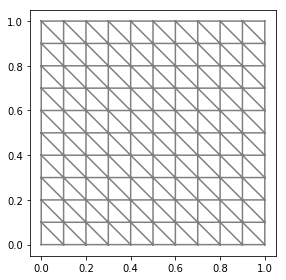

In [24]:
# Create a mesh to evaluate our function over
grid_x = 10
grid_y = 10 # Make the mesh finer by increasing these values
             # and the resulting plot will look smoother

mesh = fn.RectangleMesh(fn.Point(0, 0), fn.Point(1, 1), grid_x, grid_y, 'left')
V1 = fn.FunctionSpace(mesh, "Lagrange", 1)

fig = plt.figure(figsize=(8,4))
fn.plot(mesh)
plt.tight_layout()
plt.show()

In [25]:
# A function, "UnitBox" which is 1 everywhere on the unit square

class UnitBox(fn.UserExpression):
    def __init__(self, a, b, **kwargs):
        self.a = a
        self.b = b
        super().__init__(**kwargs)
    def eval(self, v, x):
        v[0] = 0
        if (x[0] >= self.a) & (x[1] >= self.b):
            v[0] = 1
        return v
    def value_shape(self):
        return ()

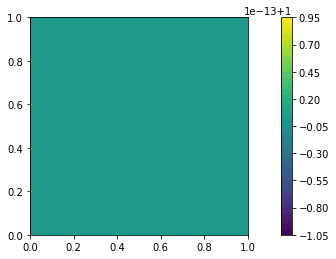

In [26]:
# Interpolate our function
my_interpolant = fn.interpolate( UnitBox(a=0, b=0, degree=1), V1)

# And plot it!
fig = plt.figure()
my_plot = fn.plot(my_interpolant)
#my_plot.set_cmap("jet")
plt.colorbar(my_plot,fraction=0.1, pad=0.1)

In [27]:
class Mollifier(fn.UserExpression):
    def __init__(self, x_pt, eps, C, **kwargs):
        self.x0 = x_pt[0]
        self.x1 = x_pt[1]
        self.eps = eps
        self.C = C
        super().__init__(**kwargs)
    def eval(self, v, x):
        v[0] = 0
        a = ( (x[0]-self.x0)**2+(x[1]-self.x1)**2 ) / eps**2
        if (a < 1):
            v[0] = (1/self.C) * fn.exp( 1 / (a-1) ) / eps**2
        return v
    def value_shape(self):
        return ()

0.9999999999999998


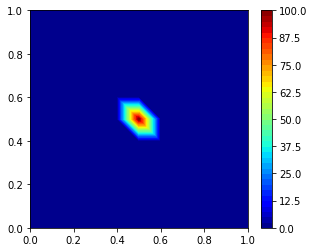

In [28]:
eps = 0.1 #The smoothing factor

C = fn.assemble( fn.interpolate(Mollifier([0.5, 0.5], eps, 1, degree=10), V1)*fn.dx ) #The normalizing constant


mollifier = fn.interpolate(Mollifier([0.5, 0.5], eps, C, degree=10), V1) #The actual mollifier

print(fn.assemble(mollifier*fn.dx)) #Check that the mollifier is properly normalized

#plot the mollifier
fig = plt.figure()
mol_plot = fn.plot(mollifier)
mol_plot.set_cmap("jet")
plt.colorbar(mol_plot,fraction=0.046, pad=0.04)

In [33]:
# Extract grid from mesh objects (first and second columns of coors and coors_compact) as numpy arrays.

coors = mesh.coordinates()

#if grid_x*grid_y < 101:
    #print(coors) 

In [34]:
u_disc_smooth_vals = np.zeros((grid_x+1)*(grid_y+1))

for i in range(coors[:,0].size):
    u_disc_smooth_vals[i] = fn.assemble(Mollifier([coors[i,0], coors[i,1]], eps, C) *
                                     my_interpolant * fn.dx)

In [35]:
# For plotting in matplotlib

mesh_X = coors[:,0].reshape((grid_x+1,grid_y+1))
mesh_Y = coors[:,1].reshape((grid_x+1,grid_y+1))

u_disc_smooth_vals = u_disc_smooth_vals.reshape((grid_x+1,grid_y+1))
u_disc_exact_vals = my_interpolant.compute_vertex_values(mesh).reshape((grid_x+1,grid_y+1))

Flushing output cache (0 entries)


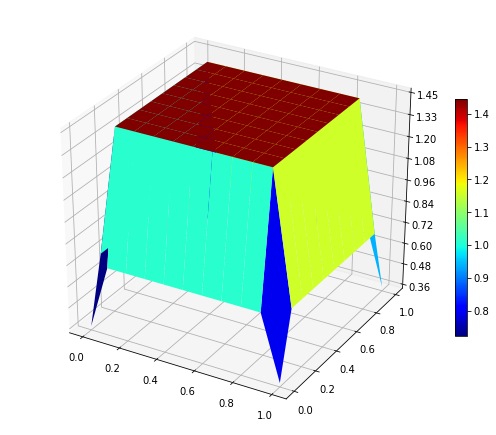

In [42]:
%reset -f out

fig = plt.figure(figsize=(7,18))
ax = plt.subplot(3,1,1, projection='3d')

# Plot the surface.
surf = ax.plot_surface(mesh_X, mesh_Y, u_disc_smooth_vals, cmap=cm.jet)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
plt.colorbar(surf,fraction=0.026, pad=0.0)
plt.tight_layout()
plt.show()

### Problem 1. (c.) 

Assume $\Omega\subset\mathbb{R}^n$ is a non-empty bounded open set so $\overline{\Omega}$ is compact and let $\{B_i\, : \, 1\leq i\leq N\}$ be an open cover of $\overline{\Omega}$. A partition of unity $\{\psi_i \, : \, 1\leq i \leq N\}$ subordinate to the cover has the property that $\psi_i\in C^\infty_c(B_i)$ for $1\leq i\leq N$, $0\leq \psi\leq 1$, and $\sum_{i=1}^N \psi_i = 1$ on $\overline{\Omega}$. Prove that a partition of unity exists. 
	
Here is a collection of facts, results, and hints which may prove useful.
		
1. There exists compact sets $K_i\subset B_i$ for $1\leq i\leq N$ such that $\overline{\Omega}\subset \cup_{i=1}^N K_i$ (why?). 

2. By part (a), for $1\leq i\leq N$ there exists $g_i\in C^\infty_c(B_i)$ such that $g_i(x)>0$ on $K_i$.

3. By part (a), there exists a smooth function $f(x)$ that is equal to $1$ on $\overline{\Omega}$ and supp$(f)\Subset \cup_{i=1}^N$ supp$(g_i)$.

4. If we let $g_{N+1}(x)=1-f(x)$, then for $1\leq i \leq N$, the functions $\psi_i(x) = g_i/\sum_{k=1}^{N+1} g_k$ are the functions we want (why? also, do not forget to check that we never divide by zero).
	

### Solution 1. (c.)

Blah

## Problem 2

Here we describe some of the continuity properties of functions in a Sobolev space on a simple domain $\Omega = (0,1)\subset\mathbb{R}$ as well as provide a computational bound on how much the function values may change as the inputs are perturbed. Absolute continuity is like a strengthened form of uniform continuity. You may recall that Lipschitz continuity is stronger than uniform continuity (i.e., all Lipschitz continuous functions are uniformly continuous). Lipschitz continuity is in fact even stronger than absolute continuity (see Example 3.57 in Hunter's notes). It probably comes as no surprise that if we ever have a choice, we would almost always choose to work with a Lipschitz continuous function. You may find reading over Section 3.A.2 in Hunter's notes to be useful (and short at just under 2 pages in length). The basic take away from absolute continuity is that this provides the necessary and sufficient condition for the fundamental theorem of calculus to hold using the Lebesgue notion of integration. Consequently, a function is absolutely continuous if and only if its weak derivative is integrable. 

### Problem 2. (a.)

Prove that if $u\in W^{1,p}(\Omega)$ for some $1\leq p < \infty$ that $u$ is equal a.e.~to an absolutely continuous function, and $u'$ (which exists a.e.) belongs to $L^p(\Omega)$.
		

1. Since $u\in W^{1,p}(\Omega)$ immediately implies that there exists weak derivative $u'\in L^p(\Omega)$, the goal here is to prove that $u'\in L^1(\Omega)$ and use Theorem 3.63 in Hunter.

2. As a first step to use Theorem 3.63 in Hunter, use Corollary 1 from my lecture 0 notes to get that $u\in L^1_{loc}(\Omega)$. 

3. H\"older's inequality states that if $p,q\in[1,\infty]$ with $1/p + 1/q = 1$ (using the convention that $1/\infty=0$), then $||fg||_{L^1}\leq ||f||_{L^p}||g||_{L^q}$. 

4. To show that $u'\in L^1(\Omega)$, use H\"older's inequality to bound $||u'||_{L^1}$ in terms of $||u'||_{L^p}$ and another function. (Hint: $u'$ is always equal to $u'$ times another function. Observe here that bounding the $L^1$-norm of $u'$ fundamentally relies upon the fact that $\Omega=(0,1)$ is a bounded subset of $\mathbb{R}$.)
	

### Solution 2. (a.)

Blah

### Problem 2. (b.) 

Prove directly that if $u\in W^{1,p}(\Omega)$ for some $1<p<\infty$, then 
		
$$|u(x)-u(y)| \leq |x-y|^{1-\frac{1}{p}}||u'||_{L^p} \ \text{ for a.e. } x,y\in \overline{\Omega} = [0,1].$$
		
		
1. By part (a), for all such $p$, $u$ is absolutely continuous and the fundamental theorem of calculus holds, i.e., we can use Theorem 3.60 in Hunter's notes to get for any $x,y\in[a,b]$ that
			
$$|u(x)-u(y)| = \left| \int_y^x u'(t) dt\right|.$$

2. Now use Holder's inequality and the fact that if $A\subset B$, then $||u'||_{L^p(A)} \leq ||u'||_{L^p(B)}$.
		
	

### Solution 2. (b.)

Blah

### Problem 2. (c.)	

Use FEniCS and the UnitIntervalMesh to numerically explore how sharp this inequality is on a couple of smooth functions and compare to the exact bound using the strong derivative. 

### Solution 2. (c.)

Blah

## Problem 3

Fill in Student To-Do's at the end of the Regularization notebook.